#  Question 6 

In [48]:
from urllib.parse import urlparse
from shapely.geometry import Point
from geopandas.tools import sjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from requests import get
import contextily as ctx
import requests
import folium
from folium.plugins import MarkerCluster
import seaborn as sns

##  - Geographic distribution map -

In [6]:
os.getcwd()

'/home/jovyan/work/foundations'

In [16]:
# Read shapefile online
def cache_data(source_url, dest_dir):
    # 确保目标目录存在
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # 解析文件名
    filename = source_url.split('/')[-1].split('?')[0]  # 假设URL以文件名结尾
    file_path = os.path.join(dest_dir, filename)

    # 如果文件不存在，则下载
    if not os.path.isfile(file_path):
        response = requests.get(source_url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
        else:
            raise Exception(f"Failed to download {source_url}")

    return file_path

In [26]:
#读取london_Boroughshapefile
London_borough = gpd.read_file(
    cache_data('https://github.com/ZhengyongLiu/FSDS_GroupAssignment_Data/blob/main/Borough/London_Borough_Excluding_MHW.zip?raw=true', 
               os.path.join('data','geo')), driver='ESRI Shapefile')

#读取csv
url ='https://raw.githubusercontent.com/OnTheMon/FSDS-project/main/Data/cleaned_data_2023.csv'
df = pd.read_csv(url)
print(len(data))

37242


ok


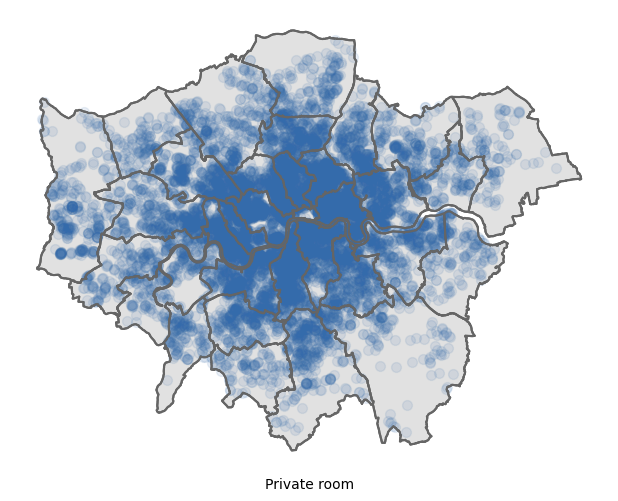

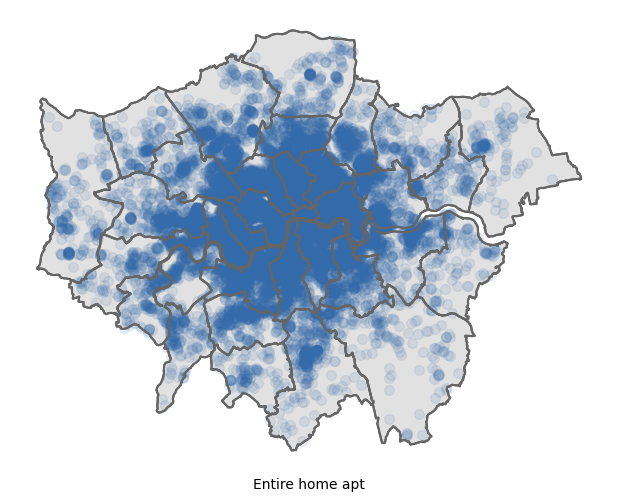

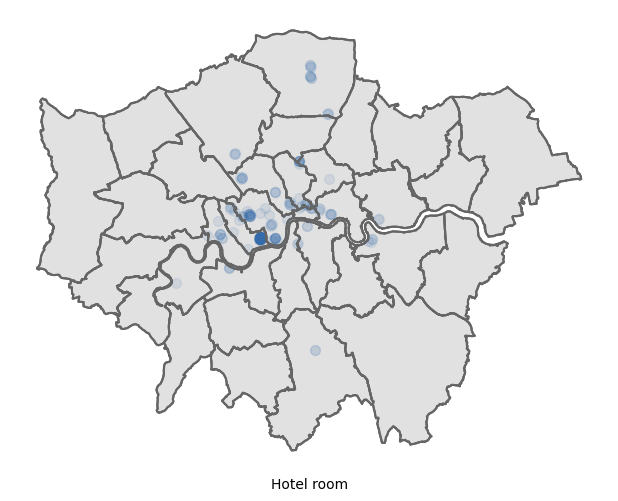

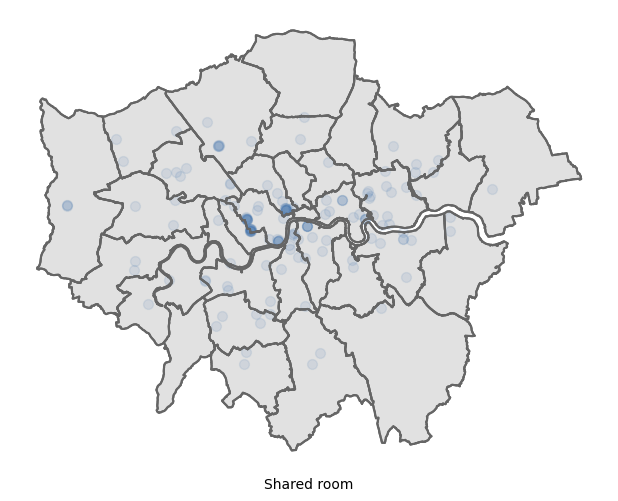

In [29]:
df = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude,df.latitude),crs = 'EPSG:4326').to_crs(London_borough.crs)

for k,room_type in enumerate(df['room_type'].unique()):
    idf = df[df['room_type']==room_type]
    room_type = room_type.replace('''/''',' ')

    figure = plt.figure(figsize=(8,6))
    ax = figure.add_subplot(1,1,1)
    London_borough.plot(ax=ax, alpha=1, edgecolor='#656565',facecolor = '#E1E1E1', linewidth=1.5)
    London_borough.plot(ax=ax, alpha=1, edgecolor='#656565',facecolor = 'none', linewidth=1.5,zorder = 10)

    img = plt.scatter(idf.geometry.x, idf.geometry.y,c = '#346BAB',s = 50,alpha=.1)
    
    for spine in ax.spines.values():
        spine.set_color('white')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.xlabel(room_type)
    plt.savefig(r'D:\HRX\CASA0013\foundations\{}.png'.format(room_type),dpi = 600)
print('ok')

In [59]:
#创建交互地图

# 房间类型地图
london_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
london_boundary = london_gdf[london_gdf['name'] == 'London']
m = folium.Map(location=[london_boundary.geometry.y.mean(), london_boundary.geometry.x.mean()], zoom_start=10)
folium.GeoJson(london_boundary).add_to(m)

# 遍历不同的房间类型
for room_type in data['room_type'].unique():
    subset = data[data['room_type'] == room_type]
    marker_cluster = MarkerCluster().add_to(m)

    # 在地图上添加标记
    for index, row in subset.iterrows():
        folium.Marker([row['latitude'], row['longitude']], popup=row['room_type']).add_to(marker_cluster)

    # 保存地图为HTML文件
    map_filename = f'/home/jovyan/work/foundations/{room_type.replace("/", "-")}.html'
    m.save(map_filename)
    print(f'Map for room_type={room_type} saved to {map_filename}')

/tmp/ipykernel_121/1522060464.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  london_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


Map for room_type=Private room saved to /home/jovyan/work/foundations/Private room.html
Map for room_type=Entire home/apt saved to /home/jovyan/work/foundations/Entire home-apt.html
Map for room_type=Hotel room saved to /home/jovyan/work/foundations/Hotel room.html
Map for room_type=Shared room saved to /home/jovyan/work/foundations/Shared room.html


## - Host type and number of listings - 

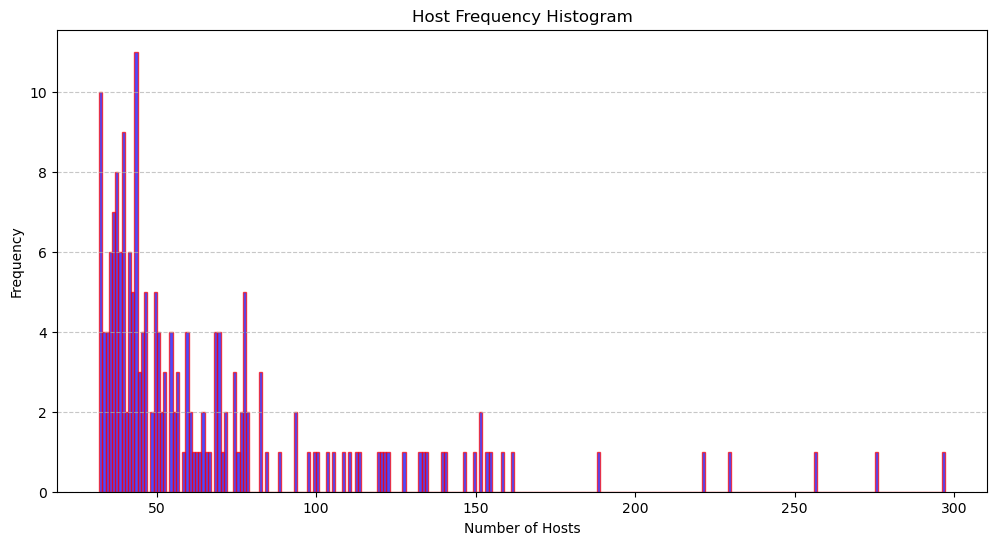

In [45]:
# Host Name Frequency Histogram
host_name_counts = data['host_name'].value_counts()
color = 'blue'
plt.figure(figsize=(12, 6))
plt.hist(host_name_counts, bins=range(32, host_name_counts.max() + 2), edgecolor='red', histtype="bar",alpha=0.7, color=color)
plt.title('Host Frequency Histogram')
plt.ylabel('Frequency')  
plt.xlabel('Number of Hosts')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## - Price distribution and competitiveness - 

<Axes: >

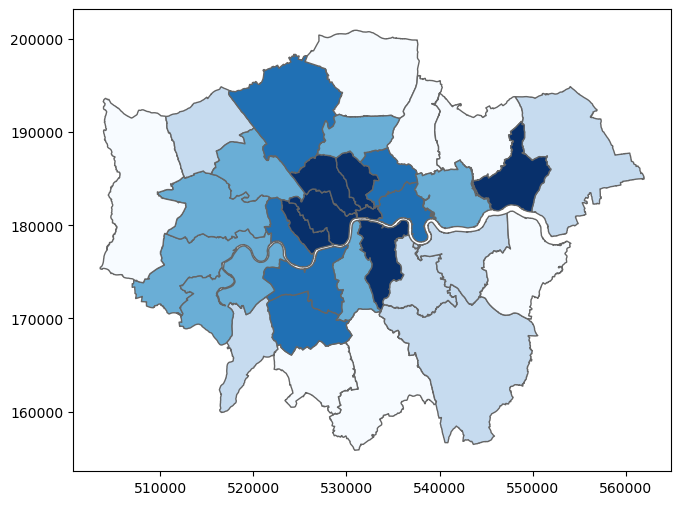

In [41]:
# 连接数据计算均值
joined = sjoin(df, London_borough, how='inner', predicate='within')

#清理数据（删除美元符号并转化为浮点数）
joined['price'] = joined['price'].replace('[\$,]', '', regex=True).astype(float)

#计算均值
meandf= joined.groupby('NAME')['price'].mean().reset_index()
gdf = London_borough.merge(meandf, on='NAME')


figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(1,1,1)
cmap = 'Blues'
gdf.plot(column='price',ax = ax,cmap = 'Blues',alpha = 1,edgecolor = '#656565', scheme='quantiles')

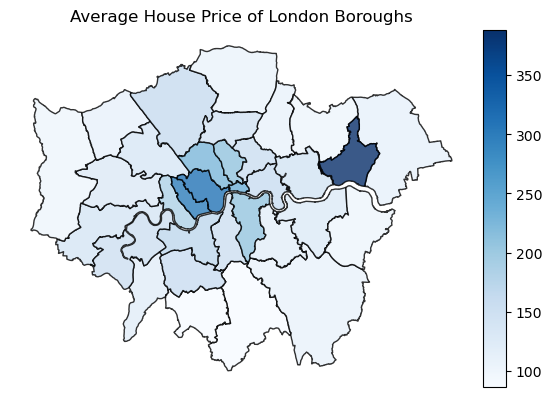

In [58]:
# 规范输出格式

# 设置颜色映射和归一化
cmap = 'Blues'
norm = mcolors.Normalize(vmin=gdf['price'].min(), vmax=gdf['price'].max())

# 创建图像和Axes对象
fig, ax = plt.subplots()

# 绘制GeoDataFrame
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot(column='price', ax=ax, cmap=cmap, legend=True, cax=cax, alpha=0.8, edgecolor='k')

# 添加颜色带
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, cax=cax)

# 添加标题和注记
ax.set_title('Average House Price of London Boroughs')

# 隐藏坐标轴
ax.axis('off')

# 保存图像
plt.savefig(r'D:\HRX\CASA0013\foundations\Average House Price of London Boroughs.png', dpi=600)

# 显示图像
plt.show()